In [11]:
from collections import OrderedDict

import numpy as np
from scipy.stats import multivariate_normal

import pickle

import matplotlib.pyplot as plt

import gen_metrics
import dists

from math import ceil, sqrt

import pandas as pd

from IPython.display import Markdown, display

plt.rcParams.update({"font.size": 16})


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

plot_dir = "../plots/toy_plots/Oct4"
_ = os.system(f"mkdir -p {plot_dir}")


In [107]:
num_batches = 5
tot_num_samples = 50_000

batch_sizes = {
    "wasserstein": [100, 200, 300, 500, 750, 1000, 1500, 2000, 2500, 3000, 4000, 5000, 7000, 10000],
    "fgd": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 5000, 7500, 10000, 15000],
    "mmdub": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000],
    "mmdu": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000],
    "mmdl": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 5000, 7500, 10000, 15000, 20000, 30000],
    "mmdup": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 5000],
    "mmdlp": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 5000, 7500, 10000, 15000, 20000, 30000, 40000, 50000],
    "mmdup4": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 5000],
    "mmdlp4": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 5000, 7500, 10000, 15000, 20000, 30000, 40000, 50000],
    "pr": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 5000],
    "dc": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 5000],
}


In [86]:
metrics = OrderedDict(
    [
        ("wasserstein", (gen_metrics.wasserstein, {}, "Wasserstein Distance")),
        ("fgd", (gen_metrics.frechet_gaussian_distance, {}, "Fréchet Gaussian Distance")),
        # ("mmdub", (gen_metrics.mmd_gaussian_quadratic_biased, {}, "MMD Quadratic Biased Est.")),
        ("mmdu", (gen_metrics.mmd_gaussian_quadratic_unbiased, {}, "MMD Quadratic Unbiased Est.")),
        ("mmdl", (gen_metrics.mmd_gaussian_linear, {}, "MMD Linear Estimator")),
        ("mmdup", (gen_metrics.mmd_poly_quadratic_unbiased, {"degree": 3}, "MMD Poly Deg=3 Quadratic Unbiased Est.")),
        ("mmdlp", (gen_metrics.mmd_poly_linear, {"degree": 3}, "MMD Poly Deg=3 Linear Estimator")),
        ("mmdup4", (gen_metrics.mmd_poly_quadratic_unbiased, {"degree": 4}, "MMD Poly Deg=4 Quadratic Unbiased Est.")),
        ("mmdlp4", (gen_metrics.mmd_poly_linear, {"degree": 4}, "MMD Poly Deg=4 Linear Estimator")),
        ("pr", (gen_metrics.pr, {}, ["Precision", "Recall"])),
        ("dc", (gen_metrics.dc, {}, ["Density", "Coverage"])),
    ]
)


In [115]:
true_var = 1.0
true_cov = 0.25
var_factor = 10
mixture_means1 = 0.6
mixture_means2 = 0.75

test_dists = [
    (
        rf"Truth N(0.0 $\mu$, {true_var} $\sigma^2$, {true_cov} cov)",
        multivariate_normal([0, 0], [[true_var, true_cov], [true_cov, true_var]]),
    ),
    (
        rf"$\mu_x$ += {sqrt(true_var)}",
        multivariate_normal([sqrt(true_var), 0], [[true_var, true_cov], [true_cov, true_var]]),
    ),
    (
        rf"$\mu_x$ += {sqrt(true_var) / 10.}",
        multivariate_normal(
            [sqrt(true_var) / 10.0, 0], [[true_var, true_cov], [true_cov, true_var]]
        ),
    ),
    (
        rf"0 cov",
        multivariate_normal(
            [0, 0], [[true_var, 0], [0, true_var]]
        ),
    ),
    (
        rf"$\sigma^2$ x= {var_factor}",
        multivariate_normal(
            [0, 0],
            [
                [true_var * var_factor, true_cov * var_factor],
                [true_cov * var_factor, true_var * var_factor],
            ],
        ),
    ),
    (
        rf"$\sigma^2$ /= {var_factor}",
        multivariate_normal(
            [0, 0],
            [
                [true_var / var_factor, true_cov / var_factor],
                [true_cov / var_factor, true_var / var_factor],
            ],
        ),
    ),
    (r"Mixture of Two Gaussians", dists.two_multivariate_normals(mixture_means1, true_var - mixture_means1 ** 2, true_cov - mixture_means1 ** 2)),
    (r"Mixture of Two Gaussians Far", dists.two_multivariate_normals(mixture_means2, true_var - mixture_means2 ** 2, true_cov - mixture_means2 ** 2)),
]

# kernel_var = gen_metrics.get_kernel_var(true_samples)
# metrics["mmdub"][1]["kernel_sigma"] = sqrt(true_var)
metrics["mmdu"][1]["kernel_sigma"] = sqrt(true_var)
metrics["mmdl"][1]["kernel_sigma"] = sqrt(true_var)


# Plot distributions

In [9]:
bound = 3
x, y = np.mgrid[-bound:bound:0.01, -bound:bound:0.01]
pos = np.dstack((x, y))

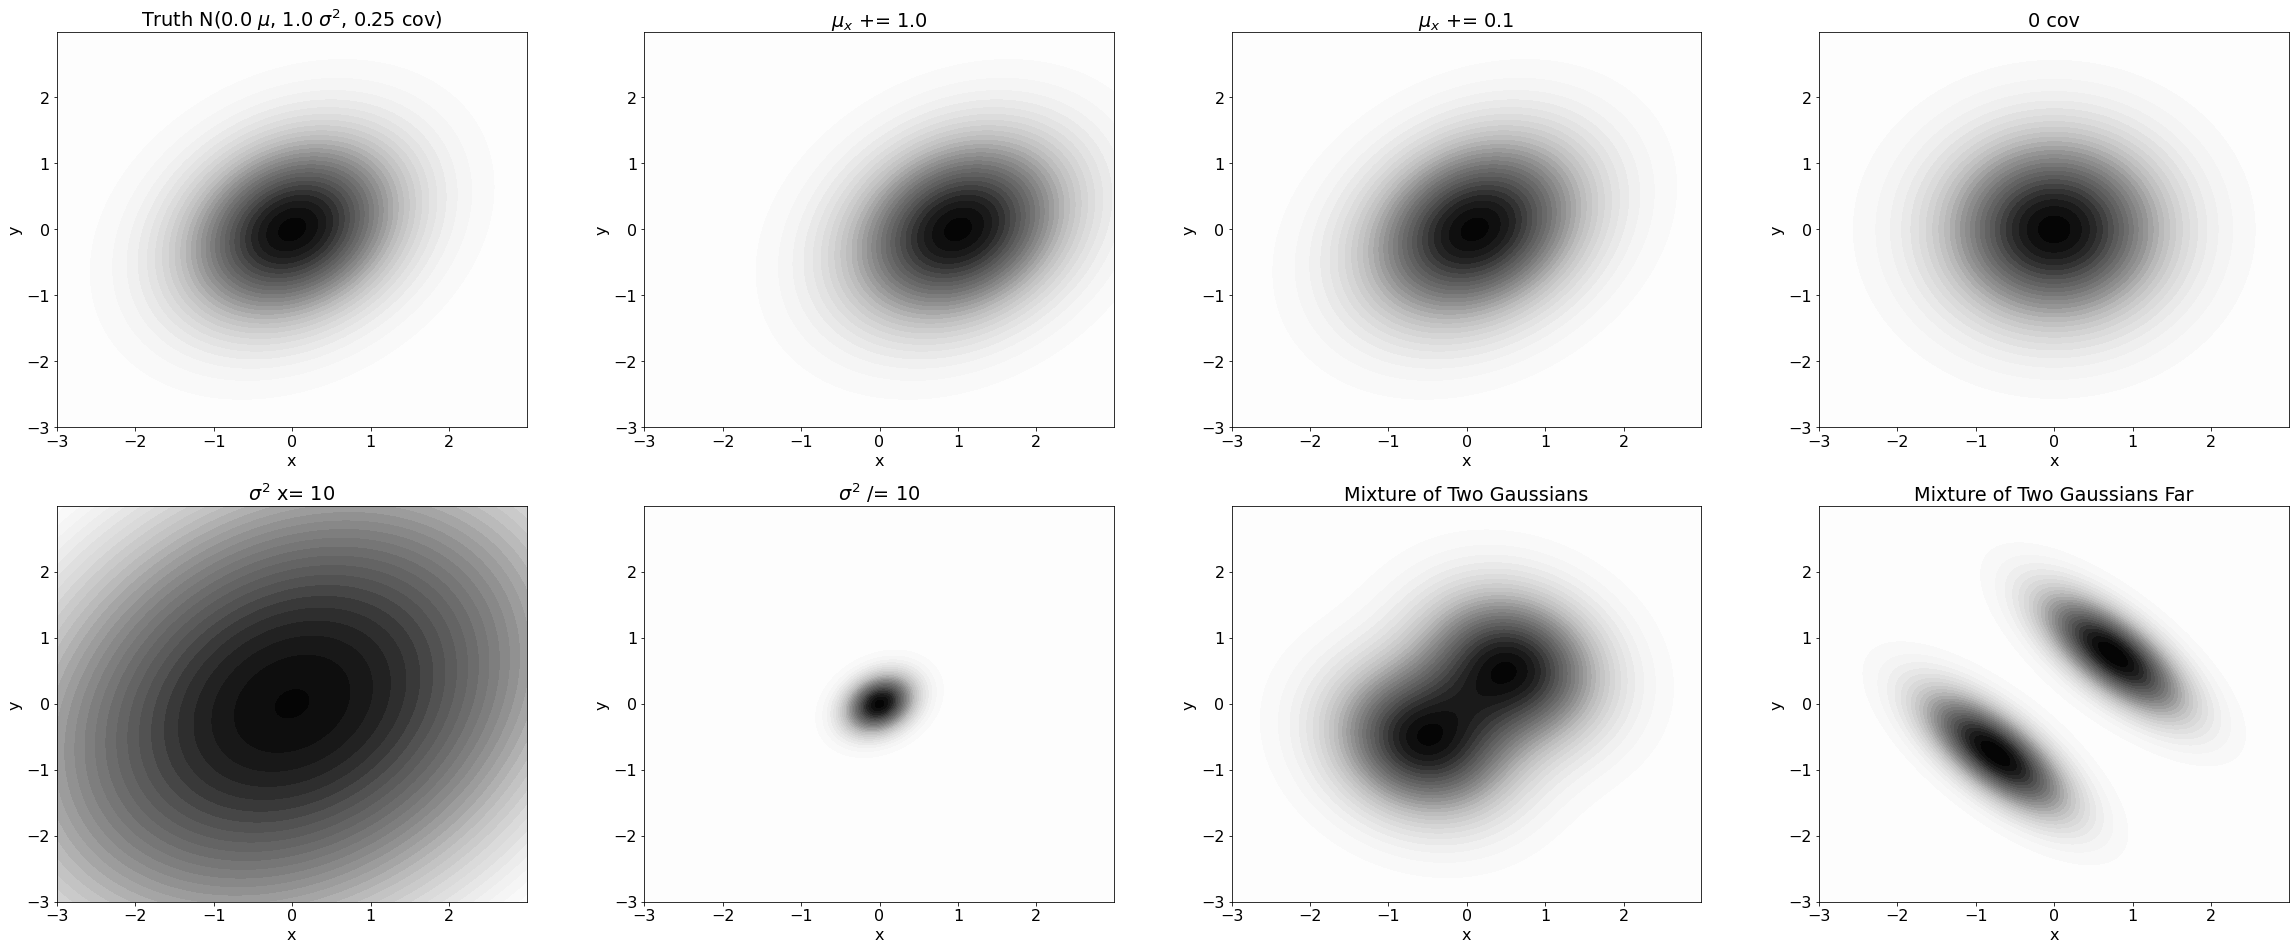

In [116]:
cm = plt.cm.Greys

nrows = 2
ncols = int(ceil(len(test_dists) / nrows))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * 10, nrows * 8),
    gridspec_kw={"wspace": 0.25},
)


for i, (label, dist) in enumerate(test_dists):
    row = i // ncols
    col = i % ncols
    axes[row][col].contourf(x, y, dist.pdf(pos), 30, cmap=cm)
    axes[row][col].set_title(label)
    axes[row][col].set_xlabel("x")
    axes[row][col].set_ylabel("y")

plt.savefig(f"{plot_dir}/test_dists.pdf", bbox_inches="tight")


# Measure metrics

In [117]:
samples = OrderedDict()

true_samples = test_dists[0][1].rvs(tot_num_samples)

for key, dist in test_dists:
    samples[key] = dist.rvs(tot_num_samples)

In [68]:
print(np.mean(samples['Mixture of Two Gaussians'], axis=0))
print(np.cov(samples['Mixture of Two Gaussians'].T))

[1.26958953e-03 6.28450828e-05]
[[1.00201253 0.24385649]
 [0.24385649 1.00221107]]


In [69]:
metrics["pr"][1]["X_nearest_neighbour_distances"] = {}
metrics["dc"][1]["X_nearest_neighbour_distances"] = {}

for batch_size in batch_sizes["pr"]:
    xnnd = gen_metrics.compute_nearest_neighbour_distances(true_samples[:batch_size])
    metrics["pr"][1]["X_nearest_neighbour_distances"][batch_size] = xnnd
    metrics["dc"][1]["X_nearest_neighbour_distances"][batch_size] = xnnd


In [118]:
if 'measurements' not in locals():
    measurements = OrderedDict()

for dkey, dist in test_dists:
    print(dkey)
    if dkey not in measurements:
        measurements[dkey] = OrderedDict()
    for mkey, (metric, metric_args, label) in metrics.items():
        if mkey in measurements[dkey] and not (mkey == "mmdup4"):  # not mkey.startswith("mmdu"): # 
            continue
        
        print(mkey)
        ms = []
        ts = []
        for batch_size in batch_sizes[mkey]:
            mean_std, timing = gen_metrics.multi_batch_evaluation(
                    true_samples, samples[dkey], num_batches, batch_size, metric, timing=True, **metric_args
                )
            ms.append(mean_std)
            ts.append(timing)
        measurements[dkey][mkey] = {"mean_std": np.array(ms), "timing": np.array(ts)}


Truth N(0.0 $\mu$, 1.0 $\sigma^2$, 0.25 cov)
mmdup4
$\mu_x$ += 1.0
mmdup4
$\mu_x$ += 0.1
mmdup4
0 cov
mmdup4
$\sigma^2$ x= 10
mmdup4
$\sigma^2$ /= 10
mmdup4
Mixture of Two Gaussians
mmdup4
Mixture of Two Gaussians Far
wasserstein


RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
/opt/anaconda3/envs/python310/lib/python3.10/site-packages/ot/lp/__init__.py:547: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
RESULT MIGHT BE INACURATE
Max number of iteration

fgd
mmdu
mmdl
mmdup
mmdlp
mmdup4
mmdlp4
pr
dc


In [50]:
if 'measurements' not in locals():
    measurements = OrderedDict()

for dkey, dist in test_dists:
    print(dkey)
    if dkey not in measurements:
        measurements[dkey] = OrderedDict()
    for mkey, (metric, metric_args, label) in metrics.items():
        if mkey in measurements[dkey] and not (mkey == "mmdup"):  # not mkey.startswith("mmdu"): # 
            continue

        ms = list(measurements[dkey][mkey]["mean_std"])
        ts = list(measurements[dkey][mkey]["timing"])

        for batch_size in batch_sizes[mkey][len(ms):]:
            mean_std, timing = gen_metrics.multi_batch_evaluation(
                    true_samples, samples[dkey], num_batches, batch_size, metric, timing=True, **metric_args
                )
            ms.append(mean_std)
            ts.append(timing)

        measurements[dkey][mkey] = {"mean_std": np.array(ms), "timing": np.array(ts)}


Truth N(0.0 $\mu$, 1.0 $\sigma^2$, 0.25 cov)
$\mu_x$ += 1.0
$\mu_x$ += 0.1
0 cov
$\sigma^2$ x= 10
$\sigma^2$ /= 10
Mixture of Two Gaussians


In [16]:
with open(f"{plot_dir}/measurements.pkl", "wb") as f:
    pickle.dump(measurements, f)

# Plot Metrics

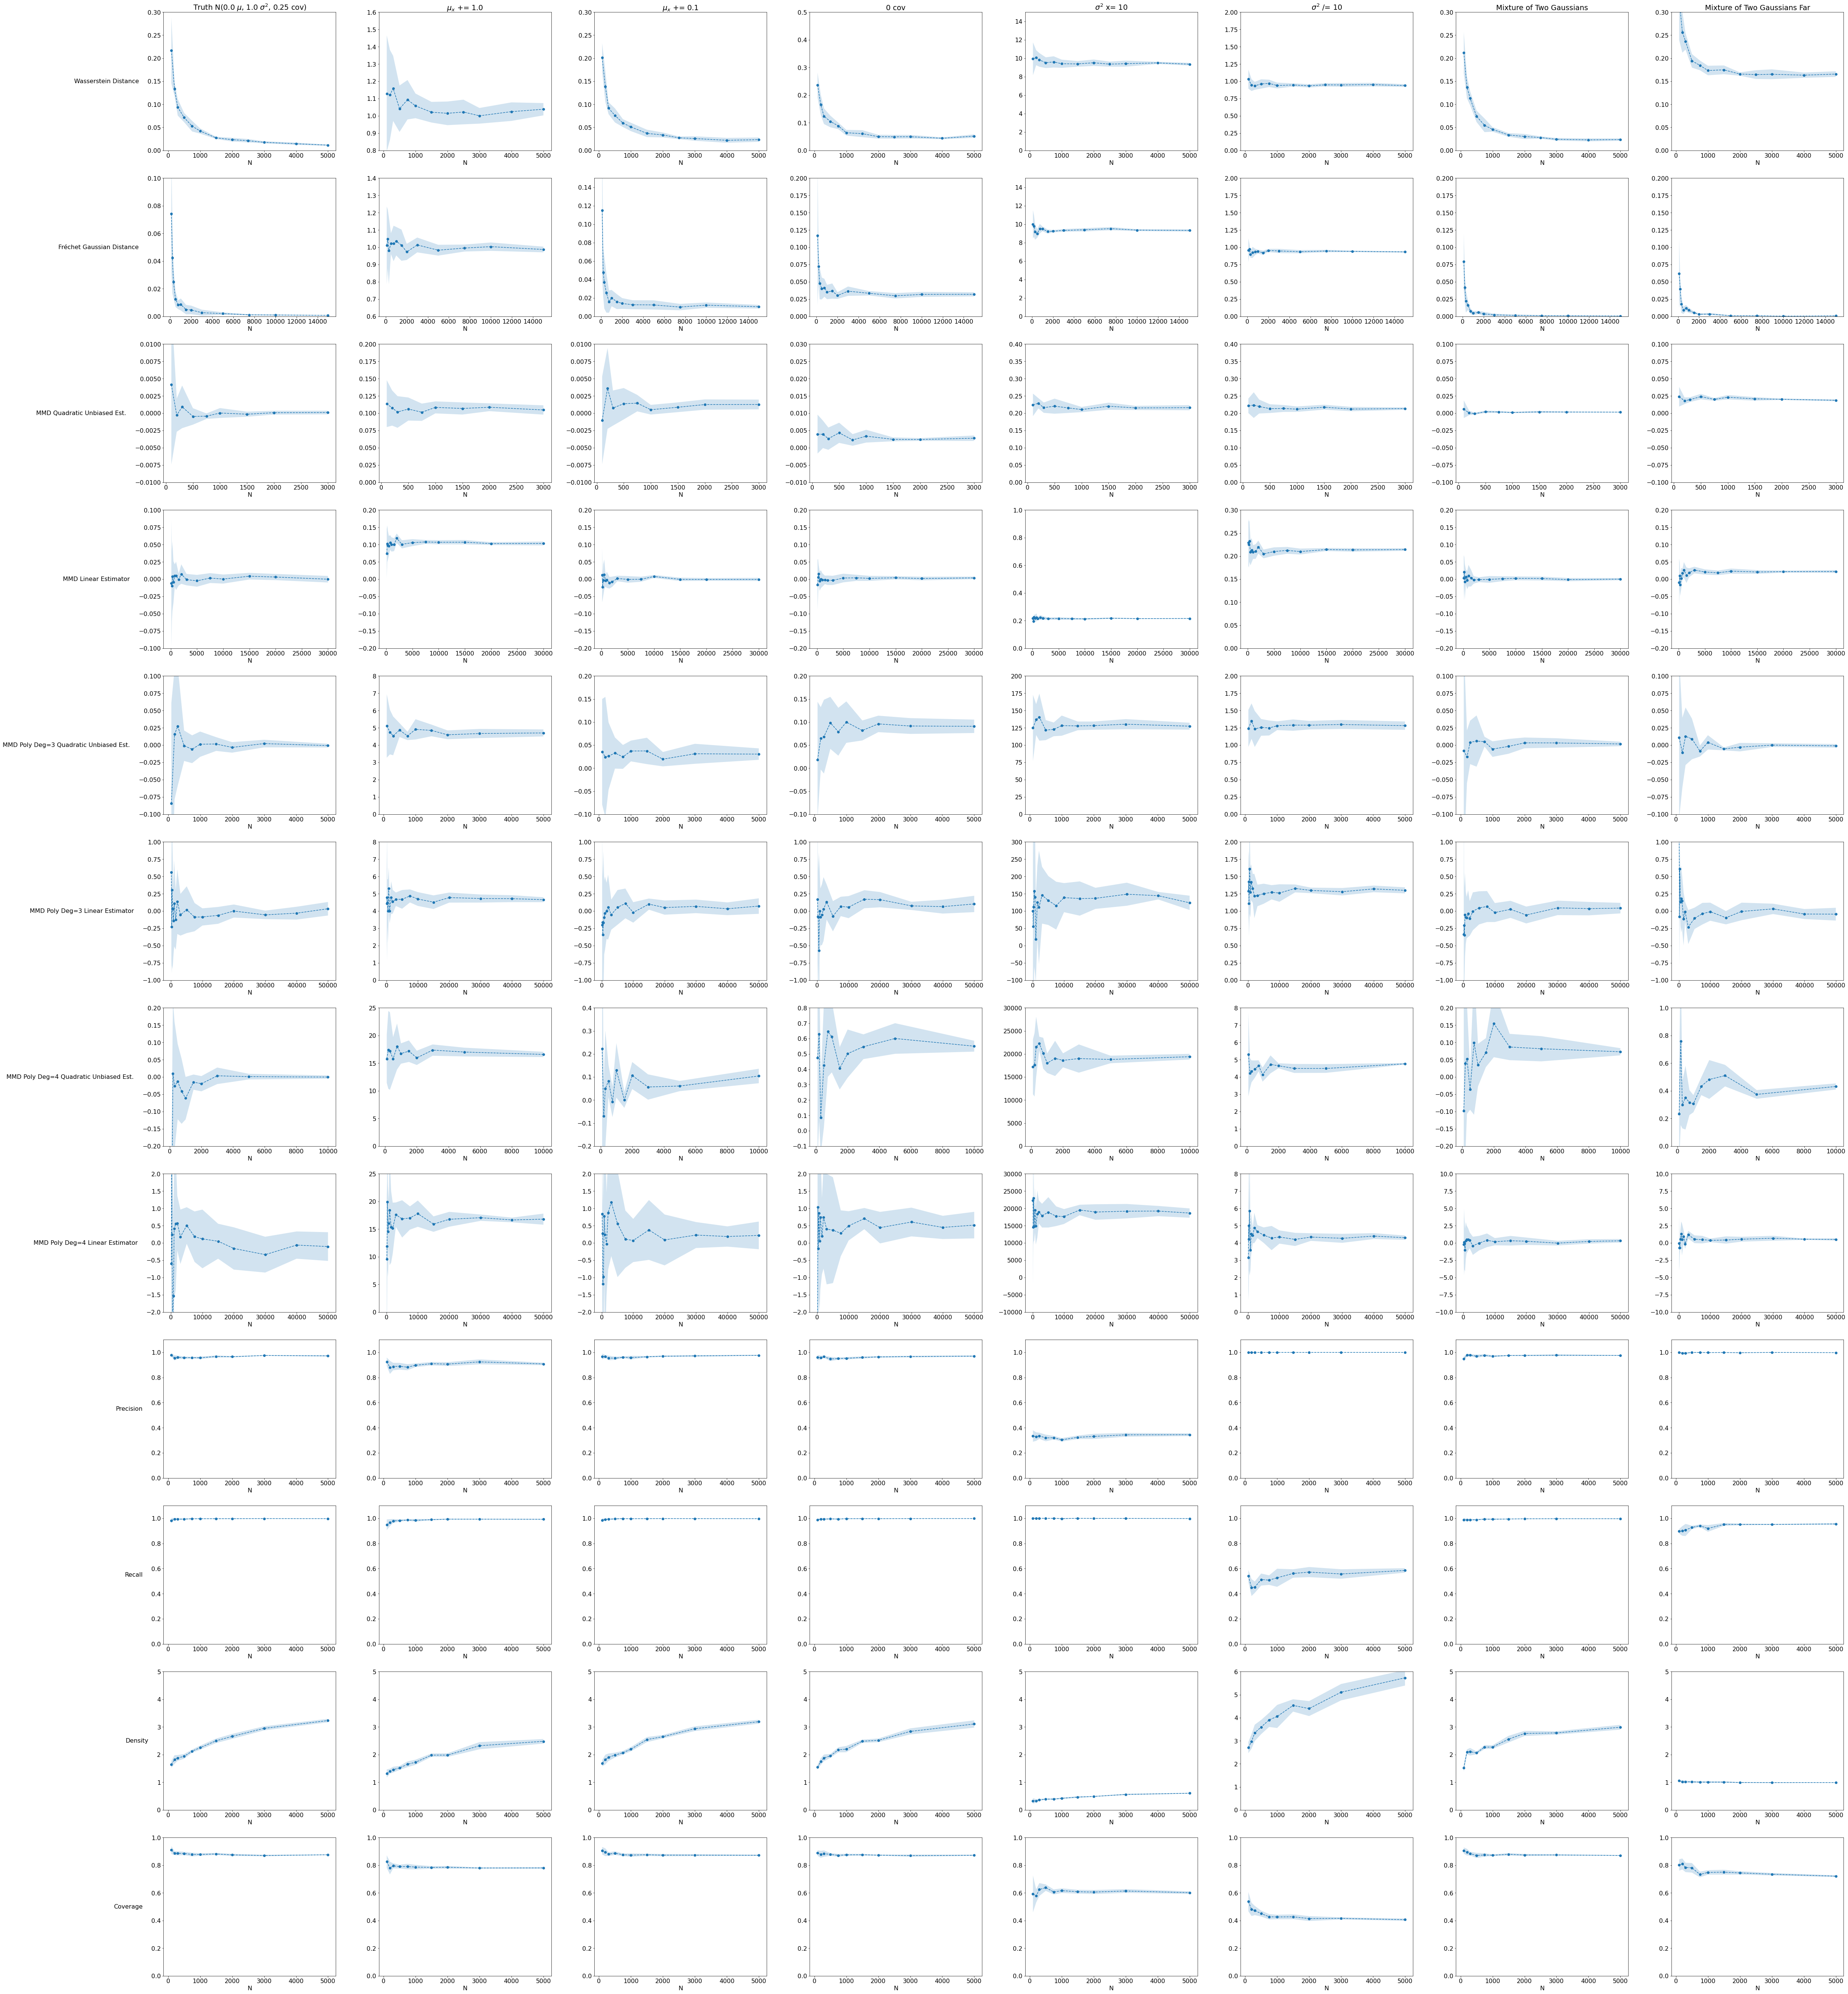

In [122]:
plt.rcParams.update({"font.size": 16})

ylims = OrderedDict(
    [
        ("wasserstein", ([0, 0.3], [0.8, 1.6], [0, 0.3], [0, 0.5], [0, 15], [0, 2], [0, 0.3], [0, 0.3])),
        ("fgd", ([0, 0.1], [0.6, 1.4], [0, 0.15], [0, 0.2], [0, 15], [0, 2], [0, 0.2], [0, 0.2])),
        # ("mmdub", ([0, 0.02], [0, 0.2], [0, 0.02], [0, 1], [0, 0.2], [-0.1, 0.1])),
        ("mmdu", ([-0.01, 0.01], [0, 0.2], [-0.01, 0.01], [-0.01, 0.03], [0, 0.4], [0, 0.4], [-0.1, 0.1], [-0.1, 0.1])),
        ("mmdl", ([-0.1, 0.1], [-0.2, 0.2], [-0.2, 0.2], [-0.2, 0.2], [0, 1], [0, 0.3], [-0.2, 0.2], [-0.2, 0.2])),
        ("mmdup", ([-0.1, 0.1], [0, 8],[-0.1, 0.2],[-0.1, 0.2],[0, 200],[0, 2],[-0.1, 0.1],[-0.1, 0.1])),
        ("mmdlp", ([-1, 1], [0, 8],[-1, 1],[-1, 1],[-100, 300],[0, 2],[-1, 1],[-1, 1])),
        ("mmdup4", ([-0.2, 0.2], [0, 25],[-0.2, 0.4],[-0.1, 0.8],[0, 30000],[0, 8],[-0.2, 0.2],[0, 1])),
        ("mmdlp4", ([-2, 2], [0, 25],[-2, 2],[-2, 2],[-10000, 30000],[0, 8],[-10, 10],[-10, 10])),
        ("precision", ([0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1])),
        ("recall", ([0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1])),
        ("density", ([0, 5], [0, 5], [0, 5], [0, 5], [0, 5], [0, 6], [0, 5], [0, 5])),
        ("coverage", ([0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1])),
    ]
)

fig, axes = plt.subplots(
    nrows=len(ylims),
    ncols=len(test_dists),
    figsize=(len(test_dists) * 10, len(ylims) * 8),
    gridspec_kw={"wspace": 0.25},
)

for i, (mkey, (metric, metric_args, label)) in enumerate(metrics.items()):
    if mkey == "prdc" or mkey == "dc" or mkey == "pr":
        continue

    axes[i][0].annotate(
        label,
        xy=(0, -1),
        xytext=(-axes[i][0].yaxis.labelpad - 15, 0),
        xycoords=axes[i][0].yaxis.label,
        textcoords="offset points",
        ha="right",
        va="center",
    )
    for j, (dkey, _) in enumerate(test_dists):
        if i == 0:
            axes[i][j].set_title(dkey)

        means = np.nan_to_num(measurements[dkey][mkey]["mean_std"][:, 0])[:len(batch_sizes[mkey])]
        stds = np.nan_to_num(measurements[dkey][mkey]["mean_std"][:, 1])[:len(batch_sizes[mkey])]

        axes[i][j].plot(
            batch_sizes[mkey],
            means,
            # np.nan_to_num(measurements[dkey][mkey]["mean_std"][:, 1]),
            marker="o",
            linestyle="--",
            # capsize=5
        )

        axes[i][j].fill_between(batch_sizes[mkey], means - stds, means + stds, alpha=0.2)
        axes[i][j].set_ylim(ylims[mkey][j])
        axes[i][j].set_xlabel("N")

for k, key in enumerate(["precision", "recall"]):
    i = len(ylims) - 4 + k
    mkey = "pr"

    axes[i][0].annotate(
        metrics[mkey][2][k],
        xy=(0, -1),
        xytext=(-axes[i][0].yaxis.labelpad - 15, 0),
        xycoords=axes[i][0].yaxis.label,
        textcoords="offset points",
        ha="right",
        va="center",
    )
    for j, (dkey, _) in enumerate(test_dists):
        if i == 0:
            axes[i][j].set_title(dkey)

        means = np.nan_to_num(measurements[dkey][mkey]["mean_std"][:, 0, k])
        stds = np.nan_to_num(measurements[dkey][mkey]["mean_std"][:, 1, k])

        axes[i][j].plot(
            batch_sizes[mkey],
            means,
            # np.nan_to_num(measurements[dkey][mkey]["mean_std"][:, 1, k]),
            marker="o",
            linestyle="--",
            # capsize=5
        )

        axes[i][j].fill_between(batch_sizes[mkey], means - stds, means + stds, alpha=0.2)
        axes[i][j].set_ylim(ylims[key][j])
        axes[i][j].set_xlabel("N")


for k, key in enumerate(["density", "coverage"]):
    i = len(ylims) - 2 + k
    mkey = "dc"

    axes[i][0].annotate(
        metrics[mkey][2][k],
        xy=(0, -1),
        xytext=(-axes[i][0].yaxis.labelpad - 15, 0),
        xycoords=axes[i][0].yaxis.label,
        textcoords="offset points",
        ha="right",
        va="center",
    )
    for j, (dkey, _) in enumerate(test_dists):
        if i == 0:
            axes[i][j].set_title(dkey)

        means = np.nan_to_num(measurements[dkey][mkey]["mean_std"][:, 0, k])
        stds = np.nan_to_num(measurements[dkey][mkey]["mean_std"][:, 1, k])

        axes[i][j].plot(
            batch_sizes[mkey],
            means,
            # np.nan_to_num(measurements[dkey][mkey]["mean_std"][:, 1, k]),
            marker="o",
            linestyle="--",
            # capsize=5
        )

        axes[i][j].fill_between(batch_sizes[mkey], means - stds, means + stds, alpha=0.2)
        axes[i][j].set_ylim(ylims[key][j])
        axes[i][j].set_xlabel("N")


plt.savefig(f"{plot_dir}/scores.pdf", bbox_inches="tight")


# Table of values

In [38]:
def disp_df(df):
    display(Markdown(df.to_markdown()))

In [120]:
rows = []

for mkey, (metric, metric_args, label) in metrics.items():
    if isinstance(label, list):
        for i, l in enumerate(label):
            row = [l]

            for dkey, values in measurements.items():
                row.append(
                    f"{values[mkey]['mean_std'][-1][0][i]:.3f} ± {values[mkey]['mean_std'][-1][1][i]:.3f}"
                )

            rows.append(row)

    else:
        row = [label]

        for dkey, values in measurements.items():
            row.append(
                f"{values[mkey]['mean_std'][-1][0]:.3f} ± {values[mkey]['mean_std'][-1][1]:.3f}"
            )

        rows.append(row)

results = pd.DataFrame(rows, columns=["Metric"] + list(measurements.keys()))

display(Markdown(results.to_markdown()))


|    | Metric                                 | Truth N(0.0 $\mu$, 1.0 $\sigma^2$, 0.25 cov)   | $\mu_x$ += 1.0   | $\mu_x$ += 0.1   | 0 cov         | $\sigma^2$ x= 10     | $\sigma^2$ /= 10   | Mixture of Two Gaussians   | Mixture of Two Gaussians 2   | Mixture of Two Gaussians Far   |
|---:|:---------------------------------------|:-----------------------------------------------|:-----------------|:-----------------|:--------------|:---------------------|:-------------------|:---------------------------|:-----------------------------|:-------------------------------|
|  0 | Wasserstein Distance                   | 0.016 ± 0.004                                  | 1.139 ± 0.024    | 0.043 ± 0.008    | 0.077 ± 0.006 | 9.792 ± 0.126        | 0.969 ± 0.013      | 0.023 ± 0.003              | 0.014 ± 0.002                | 0.166 ± 0.006                  |
|  1 | Fréchet Gaussian Distance              | 0.001 ± 0.000                                  | 0.987 ± 0.016    | 0.010 ± 0.002    | 0.032 ± 0.003 | 9.320 ± 0.121        | 0.932 ± 0.010      | 0.001 ± 0.000              | 0.001 ± 0.000                | 0.001 ± 0.000                  |
|  2 | MMD Quadratic Unbiased Est.            | 0.000 ± 0.000                                  | 0.105 ± 0.007    | 0.001 ± 0.001    | 0.003 ± 0.001 | 0.216 ± 0.007        | 0.213 ± 0.003      | 0.001 ± 0.000              | 0.000 ± 0.000                | 0.019 ± 0.001                  |
|  3 | MMD Linear Estimator                   | -0.000 ± 0.005                                 | 0.103 ± 0.006    | -0.001 ± 0.004   | 0.004 ± 0.004 | 0.216 ± 0.002        | 0.214 ± 0.003      | -0.000 ± 0.003             | -0.001 ± 0.004               | 0.022 ± 0.004                  |
|  4 | MMD Poly Deg=3 Quadratic Unbiased Est. | -0.001 ± 0.003                                 | 4.703 ± 0.204    | 0.030 ± 0.012    | 0.091 ± 0.015 | 127.319 ± 5.007      | 1.281 ± 0.060      | 0.002 ± 0.003              | 0.000 ± 0.004                | -0.001 ± 0.003                 |
|  5 | MMD Poly Deg=3 Linear Estimator        | 0.033 ± 0.098                                  | 4.655 ± 0.143    | 0.072 ± 0.112    | 0.102 ± 0.118 | 123.681 ± 20.688     | 1.299 ± 0.044      | 0.042 ± 0.076              | -0.007 ± 0.051               | -0.046 ± 0.092                 |
|  6 | MMD Poly Deg=4 Quadratic Unbiased Est. | -0.000 ± 0.005                                 | 16.576 ± 0.478   | 0.104 ± 0.031    | 0.550 ± 0.035 | 19395.900 ± 617.497  | 4.761 ± 0.048      | 0.073 ± 0.010              | 0.019 ± 0.011                | 0.431 ± 0.022                  |
|  7 | MMD Poly Deg=4 Linear Estimator        | -0.105 ± 0.415                                 | 16.797 ± 1.001   | 0.218 ± 0.400    | 0.515 ± 0.384 | 18634.225 ± 1350.991 | 4.302 ± 0.125      | 0.306 ± 0.258              | 0.038 ± 0.350                | 0.506 ± 0.157                  |
|  8 | Precision                              | 0.972 ± 0.005                                  | 0.907 ± 0.010    | 0.976 ± 0.004    | 0.969 ± 0.006 | 0.345 ± 0.011        | 1.000 ± 0.000      | 0.975 ± 0.003              | 0.998 ± 0.001                | 0.997 ± 0.001                  |
|  9 | Recall                                 | 0.997 ± 0.001                                  | 0.992 ± 0.003    | 0.997 ± 0.001    | 0.998 ± 0.001 | 0.998 ± 0.001        | 0.585 ± 0.018      | 0.996 ± 0.001              | 0.997 ± 0.001                | 0.955 ± 0.006                  |
| 10 | Density                                | 3.230 ± 0.063                                  | 2.480 ± 0.083    | 3.190 ± 0.071    | 3.107 ± 0.132 | 0.603 ± 0.015        | 5.731 ± 0.336      | 2.990 ± 0.087              | 0.989 ± 0.009                | 0.988 ± 0.004                  |
| 11 | Coverage                               | 0.876 ± 0.002                                  | 0.780 ± 0.006    | 0.872 ± 0.005    | 0.872 ± 0.004 | 0.602 ± 0.010        | 0.406 ± 0.008      | 0.871 ± 0.002              | 0.956 ± 0.006                | 0.721 ± 0.006                  |

In [81]:
measurements["Mixture of Two Gaussians"]["mmdup"]

{'mean_std': array([[-0.00803916,  0.15587404],
        [-0.01693323,  0.0381682 ],
        [ 0.00389475,  0.03147172],
        [ 0.00582284,  0.03704525],
        [ 0.00491563,  0.00708939],
        [-0.00583929,  0.01127152],
        [-0.00186848,  0.01070431],
        [ 0.00315811,  0.00779365],
        [ 0.00310057,  0.00681316],
        [ 0.00163034,  0.00328143]]),
 'timing': array([[8.95977020e-04, 7.49111176e-04, 6.65903091e-04, 6.36339188e-04,
         6.35862350e-04, 6.32047653e-04, 6.35862350e-04, 6.36100769e-04,
         6.37769699e-04, 6.38246536e-04],
        [2.58517265e-03, 2.53105164e-03, 2.48718262e-03, 2.71892548e-03,
         2.48098373e-03, 2.39896774e-03, 2.83002853e-03, 2.73299217e-03,
         2.41994858e-03, 2.72107124e-03],
        [5.52916527e-03, 5.35297394e-03, 5.60688972e-03, 5.29003143e-03,
         5.37991524e-03, 5.61308861e-03, 5.36990166e-03, 5.33986092e-03,
         5.66816330e-03, 5.35297394e-03],
        [1.65190697e-02, 1.82178020e-02, 1.65359974e

In [56]:
results.to_csv(f"{plot_dir}/scores.csv")

# Plot Timings

In [111]:
timings = OrderedDict()

for mkey in metrics:
    mtimings = []
    for i, batch_size in enumerate(batch_sizes[mkey]):
        mbtimings = []
        for values in measurements.values():
            mbtimings.append(values[mkey]['timing'][i])
        
        mtimings.append([np.mean(mbtimings), np.std(mbtimings)])

    timings[mkey] = np.array(mtimings)


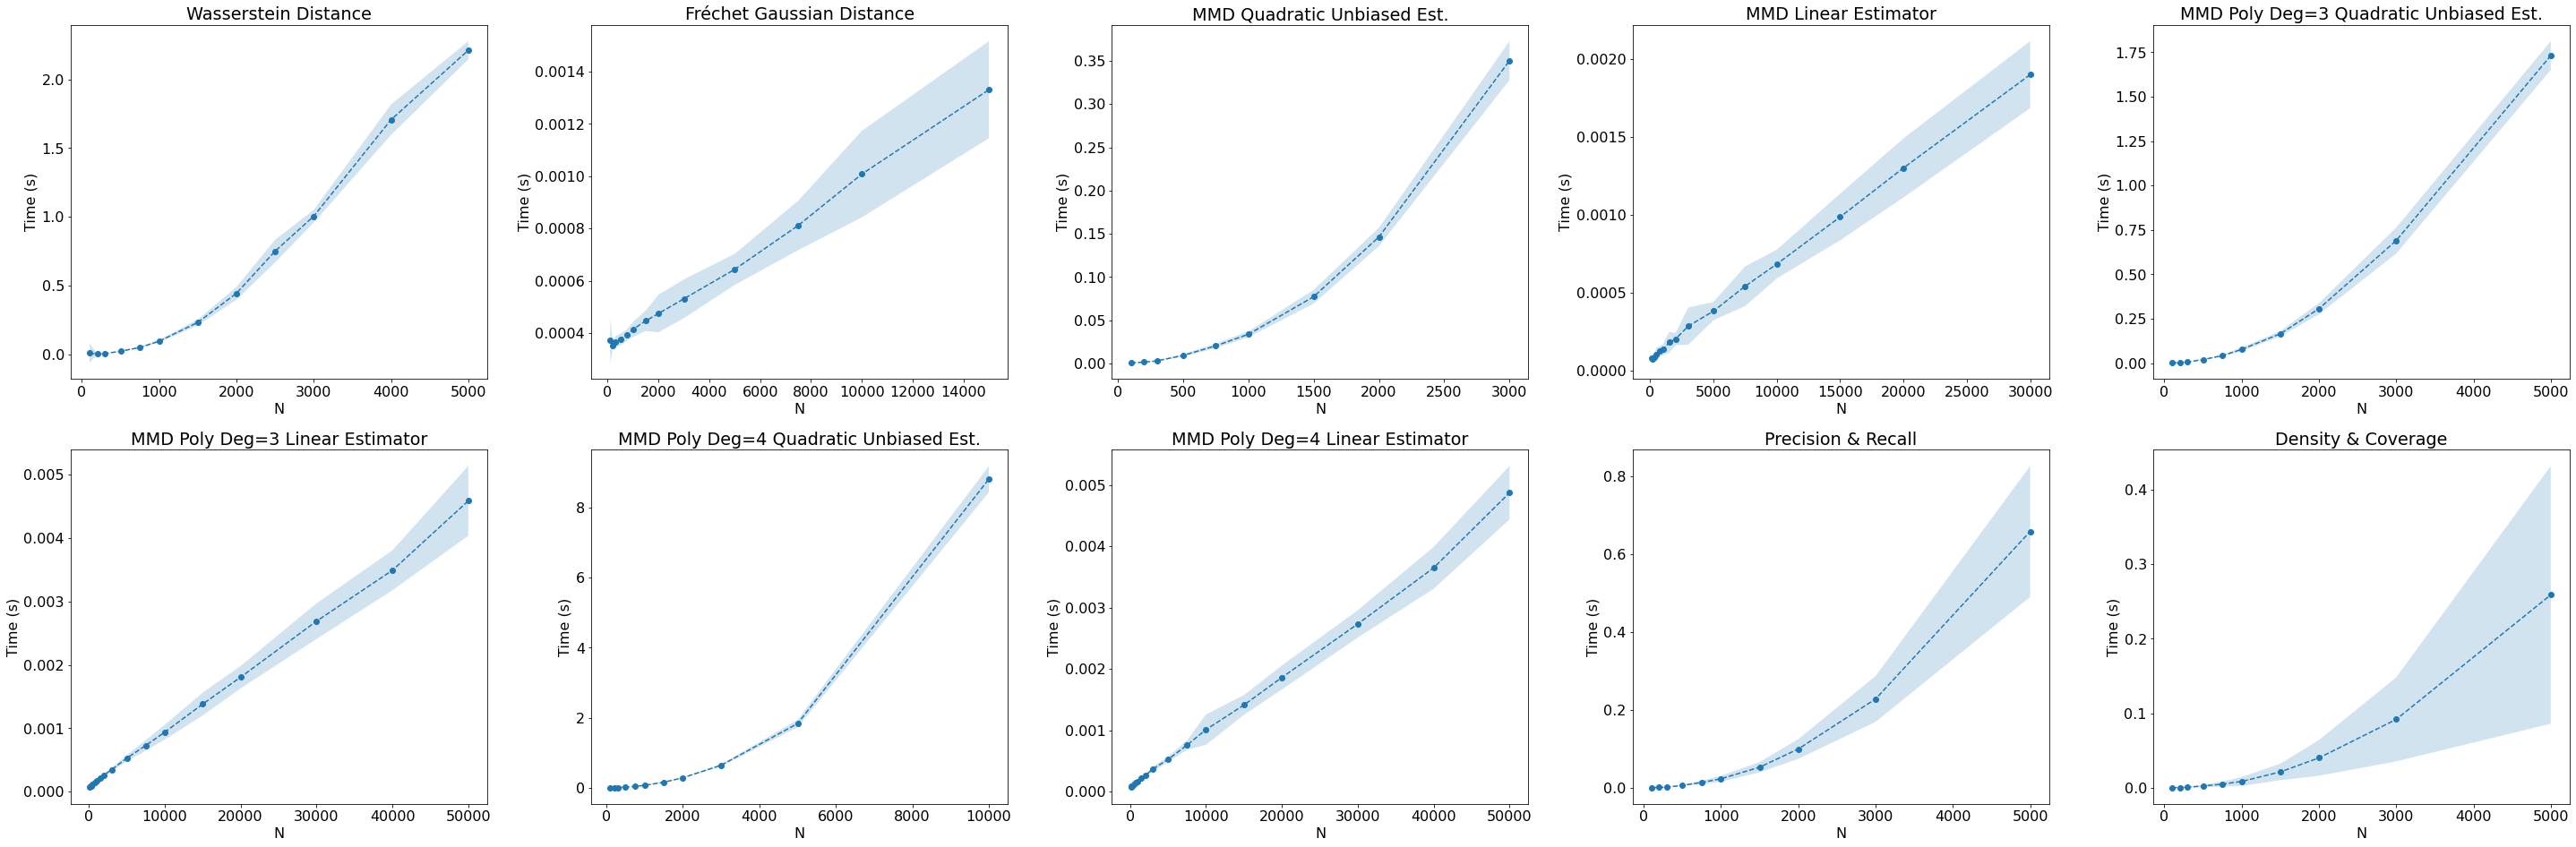

In [112]:
plt.rcParams.update({"font.size": 16})

nrows = 2
ncols = int(ceil(len(metrics) / nrows))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * 10, nrows * 8),
    gridspec_kw={"wspace": 0.25},
)

for i, (mkey, (metric, metric_args, label)) in enumerate(metrics.items()):
    row = i // ncols
    col = i % ncols

    if isinstance(label, list):
        label = " & ".join(label)

    means = timings[mkey][:, 0][:len(batch_sizes[mkey])]
    stds = timings[mkey][:, 1][:len(batch_sizes[mkey])]

    axes[row][col].plot(
        batch_sizes[mkey][:len(means)],
        means,
        marker="o",
        linestyle="--",
    )

    axes[row][col].fill_between(batch_sizes[mkey][:len(means)], means - stds, means + stds, alpha=0.2)
    axes[row][col].set_title(label)
    axes[row][col].set_xlabel("N")
    axes[row][col].set_ylabel("Time (s)")

plt.savefig(f"{plot_dir}/timings.pdf", bbox_inches="tight")